In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

## Classification and Imputation using Auto-Encoder

The idea is to train a dense neural network as an auto-encoder to fill in missing values.


## Outputs
Creates output files in the "predictions" directory.
Imputes as much as possible all NaNs in both train and test files and adds predictions.

**IMPORTANT**: Preidictions in the train set were created by the Auto-Encoder!!


In [2]:
# Load data
train = pd.read_csv('data/trainSet.txt')
test = pd.read_csv('data/testSet.txt')

In [3]:
# definde columns of interest
cols_out = ['PatientID', 'ImageFile', 'Hospital', 'Prognosis']
binary_vars = ['RespiratoryFailure', 'Sex', 'Cough', 'DifficultyInBreathing', 'CardiovascularDisease']
impute_cols = [i for i in train.columns if i not in cols_out]

## Autoencoder should work!

In [4]:
def create_model():
    
    regularizer = keras.regularizers.l1_l2(l1=0, l2=0.0015)
    
    inputs = keras.Input(shape=(16,))
    x = keras.layers.Dense(16, activation='selu')(inputs)
    # build a little auto-encoder
    x = keras.layers.Dense(100, activation='selu', kernel_regularizer=regularizer, name='expand')(x)
    x = keras.layers.Dropout(0.45)(x)
    # bottleneck
    x = keras.layers.Dense(4, activation='selu', kernel_regularizer=regularizer, name='bottleneck')(x)
    x = keras.layers.Dropout(0.45)(x)
    x = keras.layers.Dense(100, activation='selu', kernel_regularizer=regularizer, name='reconstruct')(x)
    x = keras.layers.Dropout(0.45)(x)
    
    out1 = keras.layers.Dense(16, activation='sigmoid', name='imputing')(x)
    out2 = keras.layers.Dense(1, activation='sigmoid', name='classifying')(x)
    
    model = keras.Model(inputs, {'impute': out1, 'classify':out2})
    
    return model

In [5]:
# From https://github.com/keras-team/keras/issues/7065
# Calculate MSE only on known values
def masked_mse(mask_value=-1):
    def f(y_true, y_pred):
        mask_true = K.cast(K.not_equal(y_true, mask_value), K.floatx())
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.sum(mask_true, axis=-1)
        return masked_mse * 100

    return f


# Validate imputation by removing one nan extra per column
def imputer_validation(valid_set):
    """
    Function to remove extra fields from data for validation.
    """
    fields_removed = valid_set.copy()
    imputer_mask = np.zeros(valid_set.shape)
    for n, row in enumerate(fields_removed):
        non_nan = np.where(row != -1)[0]
        set_nan = np.random.choice(non_nan)
        fields_removed[n, set_nan] = -1
        imputer_mask[n, set_nan] = True
    
    return fields_removed, imputer_mask


# helper to calculate scores
def calculate_score(x_true, x_pred, errorfun='mse', scaler=None):
    if scaler:
        x_true = scaler.inverse_transform(x_true.copy())
        x_pred = scaler.inverse_transform(x_pred.copy())
        x_true = np.clip(x_true, a_min=-1, a_max=None)
        x_pred = np.clip(x_pred, a_min=-1, a_max=None)
    if errorfun == 'mse':
        score = mean_squared_error(x_true, x_pred)
    elif errorfun == 'acc':
        score = accuracy_score(x_true, x_pred > 0.5)
    elif errorfun == "masked_mse":
        score = masked_mse(-1)(x_true, x_pred)
        score = np.mean(score)
    
    return score


def post_processing(original_df, predicted_values, classify, scaler=None):
    # Post processing
    nan_mask = np.isnan(original_df)
    previous_values = original_df.copy().values
    imputed_thing = np.zeros(previous_values.shape)

    # Rescale values and add to empty matrix
    if scaler is not None:
        predicted_values = MM.inverse_transform(predicted_values)
    
    imputed_thing[nan_mask] = predicted_values[nan_mask]
    # Clip negatives
    imputed_thing = np.clip(imputed_thing, a_min=0, a_max=None) 
    # Add known values
    imputed_thing[nan_mask==False] = previous_values[nan_mask==False]
    
    # Add classification and column names, binarize binary values
    df_out = pd.DataFrame(imputed_thing, columns=original_df.columns)
    df_out[binary_vars] = (df_out[binary_vars] > 0.5) * 1.0
    df_out['Prognosis'] = classify > 0.5
    
    return df_out

In [6]:
# some global vars
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
OPTIMIZER = keras.optimizers.Adam(lr=0.001)
CALLBACKS = [early_stopping]
LOSS = {'impute': masked_mse(), 'classify': 'binary_crossentropy'}

In [7]:
# Preprare data for training
train_clean = train[impute_cols]
train_y = train['Prognosis'] == 'MILD'

In [8]:
accs, mses0, mses1, imps0, imps1, trues, preds, indices, hosp_val = [], [], [], [], [], [], [], [], []

train_mask = np.isnan(train_clean).values

for hosp in np.unique(train.Hospital):
    model = create_model()
    model.compile(optimizer=OPTIMIZER, 
                  loss=LOSS,
                  metrics={'impute': 'mse', 'classify': 'accuracy'})
    MM = MinMaxScaler(clip=True)
    
    tr = np.where(train.Hospital != hosp)[0]
    vl = np.where(train.Hospital == hosp)[0]

    # Remove Nans
    x_train = train_clean.iloc[tr].copy().fillna(0)
    x_valid = train_clean.iloc[vl].copy().fillna(0)
    # Define y-values
    y_train = train_y.iloc[tr]
    y_valid = train_y.iloc[vl]
    # Scale data from 0 to 1
    x_train = MM.fit_transform(x_train)
    x_valid = MM.transform(x_valid)
    
    # Set former nan values to -1
    x_train[train_mask[tr]] = -1
    x_valid[train_mask[vl]] = -1
    
    # Fit Model
    model.fit(x_train, {'impute':x_train, 'classify': y_train}, verbose=0, 
              callbacks=CALLBACKS, validation_split=0.15,
             epochs=250)
    
    # Predict the things
    prediction = model.predict(x_valid)
    preds.append(MM.inverse_transform(prediction['impute']))

    pred_val, pred_y = prediction['impute'], prediction['classify']
    
    
    # Returns metrics, weirdly
    _, _, _, train_acc, train_mse = model.evaluate(x_train, 
                                                   {'impute':x_train, 
                                                    'classify': y_train}, 
                                                   verbose=0)
    
    # Set previous NAN to -1
    pred_val[train_mask[vl]] = -1
    x_valid[train_mask[vl]] = -1
    
    # imputer validation:
    x_impute, impute_mask = imputer_validation(x_valid)
    
    imputer_predict = model.predict(x_impute)['impute']
    imputer_predict[impute_mask==False] = -1
    
    validation_mask = x_valid.copy()
    validation_mask[impute_mask==False] = -1
    
    # imputer error
    imp0 = calculate_score(validation_mask, 
                            imputer_predict, errorfun='masked_mse')
    imp1 = calculate_score(validation_mask, 
                            imputer_predict, errorfun='masked_mse', scaler=MM)
    
    # Keepingt track
    imps0.append(imp0)
    imps1.append(imp1)
    mses0.append(calculate_score(x_valid, pred_val, scaler=MM, errorfun='masked_mse'))
    mses1.append(calculate_score(x_valid, pred_val, errorfun='masked_mse'))
    accs.append(calculate_score(y_valid, pred_y, errorfun='acc'))
    trues.append(MM.inverse_transform(x_valid))
    preds.append(MM.inverse_transform(prediction['impute']))
    print(f"Split {hosp}, with validation n = {x_valid.shape[0]}: \nRescaled MSE - {mses0[-1]:4.2f} " +
          f"MSE - {mses1[-1]:4.2f} " +
          f"Acc - {accs[-1]:4.2f}\n" +
          f"Impute MSE - {imps0[-1]:4.2f} " +
          f"Impute MSE scaled - {imps1[-1]:4.2f}")
          
    print(f"Train - MSE {train_mse:4.3f}, ACC {train_acc:4.3f}")
    
    indices.append(vl)
    hosp_val.append([hosp] * len(vl))
    print("==============================================")

Split B, with validation n = 104: 
Rescaled MSE - 77761888.00 MSE - 1.30 Acc - 0.68
Impute MSE - 13.20 Impute MSE scaled - 3162536.00
Train - MSE 0.557, ACC 0.635
Split C, with validation n = 31: 
Rescaled MSE - 7332075.00 MSE - 1.93 Acc - 0.42
Impute MSE - 17.05 Impute MSE scaled - 7339283.00
Train - MSE 0.521, ACC 0.625
Split D, with validation n = 139: 
Rescaled MSE - 120867256.00 MSE - 4.98 Acc - 0.66
Impute MSE - 15.27 Impute MSE scaled - 14111641.00
Train - MSE 0.549, ACC 0.628
Split E, with validation n = 101: 
Rescaled MSE - 169529.28 MSE - 1.62 Acc - 0.61
Impute MSE - 16.29 Impute MSE scaled - 58205.94
Train - MSE 0.533, ACC 0.635
Split F, with validation n = 488: 
Rescaled MSE - 90677592.00 MSE - 2.27 Acc - 0.63
Impute MSE - 12.73 Impute MSE scaled - 243871744.00
Train - MSE 0.489, ACC 0.693


# Final Training and Creating Test Set

In [9]:
model = create_model()
model.compile(optimizer=OPTIMIZER, 
                  loss=LOSS,
                  metrics={'impute': 'mae', 'classify': 'accuracy'})

MM = MinMaxScaler(clip=True)

# Transform Data:
x_train = train_clean.copy().fillna(0)
# Define y-values
y_train = train_y
# Scale data from 0 to 1
x_train = MM.fit_transform(x_train)
# Set former nan values to -1
x_train[train_mask] = -1


model.fit(x_train, {'impute':x_train, 'classify': y_train}, verbose=1, callbacks=CALLBACKS, 
          validation_split=0.15, epochs=250)

Epoch 1/250
23/23 [==============================] - 1s 24ms/step - loss: 14.3273 - classifying_loss: 0.8018 - imputing_loss: 13.4637 - classifying_accuracy: 0.4966 - imputing_mae: 0.5412 - val_loss: 8.8755 - val_classifying_loss: 0.6988 - val_imputing_loss: 8.1168 - val_classifying_accuracy: 0.4385 - val_imputing_mae: 0.5005
Epoch 2/250
23/23 [==============================] - 0s 5ms/step - loss: 10.0739 - classifying_loss: 0.7440 - imputing_loss: 9.2719 - classifying_accuracy: 0.4952 - imputing_mae: 0.4828 - val_loss: 7.9447 - val_classifying_loss: 0.6662 - val_imputing_loss: 7.2224 - val_classifying_accuracy: 0.6385 - val_imputing_mae: 0.4899
Epoch 3/250
23/23 [==============================] - 0s 4ms/step - loss: 8.8550 - classifying_loss: 0.7127 - imputing_loss: 8.0875 - classifying_accuracy: 0.5252 - imputing_mae: 0.4653 - val_loss: 7.1605 - val_classifying_loss: 0.6611 - val_imputing_loss: 6.4462 - val_classifying_accuracy: 0.6462 - val_imputing_mae: 0.4810
Epoch 4/250
23/23 [==

23/23 [==============================] - 0s 4ms/step - loss: 5.6159 - classifying_loss: 0.6801 - imputing_loss: 4.8931 - classifying_accuracy: 0.5730 - imputing_mae: 0.4167 - val_loss: 3.1589 - val_classifying_loss: 0.6564 - val_imputing_loss: 2.4600 - val_classifying_accuracy: 0.6385 - val_imputing_mae: 0.4269
Epoch 27/250
23/23 [==============================] - 0s 5ms/step - loss: 5.5237 - classifying_loss: 0.6670 - imputing_loss: 4.8143 - classifying_accuracy: 0.5839 - imputing_mae: 0.4164 - val_loss: 3.1811 - val_classifying_loss: 0.6607 - val_imputing_loss: 2.4782 - val_classifying_accuracy: 0.6462 - val_imputing_mae: 0.4271
Epoch 28/250
23/23 [==============================] - 0s 5ms/step - loss: 5.4836 - classifying_loss: 0.6724 - imputing_loss: 4.7689 - classifying_accuracy: 0.5716 - imputing_mae: 0.4157 - val_loss: 3.1993 - val_classifying_loss: 0.6610 - val_imputing_loss: 2.4961 - val_classifying_accuracy: 0.6308 - val_imputing_mae: 0.4262
Epoch 29/250
23/23 [===============

23/23 [==============================] - 0s 4ms/step - loss: 5.5055 - classifying_loss: 0.6800 - imputing_loss: 4.7862 - classifying_accuracy: 0.5825 - imputing_mae: 0.4125 - val_loss: 2.9870 - val_classifying_loss: 0.6594 - val_imputing_loss: 2.2885 - val_classifying_accuracy: 0.6615 - val_imputing_mae: 0.4205
Epoch 52/250
23/23 [==============================] - 0s 4ms/step - loss: 5.1270 - classifying_loss: 0.6681 - imputing_loss: 4.4198 - classifying_accuracy: 0.5962 - imputing_mae: 0.4091 - val_loss: 2.9508 - val_classifying_loss: 0.6550 - val_imputing_loss: 2.2567 - val_classifying_accuracy: 0.6462 - val_imputing_mae: 0.4196
Epoch 53/250
23/23 [==============================] - 0s 3ms/step - loss: 5.2278 - classifying_loss: 0.6792 - imputing_loss: 4.5095 - classifying_accuracy: 0.5825 - imputing_mae: 0.4102 - val_loss: 3.0391 - val_classifying_loss: 0.6593 - val_imputing_loss: 2.3409 - val_classifying_accuracy: 0.6538 - val_imputing_mae: 0.4202
Epoch 54/250
23/23 [===============

23/23 [==============================] - 0s 4ms/step - loss: 5.2576 - classifying_loss: 0.6593 - imputing_loss: 4.5604 - classifying_accuracy: 0.6166 - imputing_mae: 0.4099 - val_loss: 2.8599 - val_classifying_loss: 0.6582 - val_imputing_loss: 2.1639 - val_classifying_accuracy: 0.6538 - val_imputing_mae: 0.4171
Epoch 77/250
23/23 [==============================] - 0s 4ms/step - loss: 5.0570 - classifying_loss: 0.6675 - imputing_loss: 4.3516 - classifying_accuracy: 0.5880 - imputing_mae: 0.4069 - val_loss: 2.8907 - val_classifying_loss: 0.6607 - val_imputing_loss: 2.1919 - val_classifying_accuracy: 0.6385 - val_imputing_mae: 0.4170
Epoch 78/250
23/23 [==============================] - 0s 4ms/step - loss: 5.0513 - classifying_loss: 0.6710 - imputing_loss: 4.3422 - classifying_accuracy: 0.6098 - imputing_mae: 0.4070 - val_loss: 2.8503 - val_classifying_loss: 0.6565 - val_imputing_loss: 2.1556 - val_classifying_accuracy: 0.6462 - val_imputing_mae: 0.4161
Epoch 79/250
23/23 [===============

23/23 [==============================] - 0s 3ms/step - loss: 5.0086 - classifying_loss: 0.6688 - imputing_loss: 4.3005 - classifying_accuracy: 0.5989 - imputing_mae: 0.4049 - val_loss: 2.5260 - val_classifying_loss: 0.6616 - val_imputing_loss: 1.8251 - val_classifying_accuracy: 0.6462 - val_imputing_mae: 0.4114
Epoch 102/250
23/23 [==============================] - 0s 3ms/step - loss: 5.0468 - classifying_loss: 0.6758 - imputing_loss: 4.3316 - classifying_accuracy: 0.6003 - imputing_mae: 0.4055 - val_loss: 2.5288 - val_classifying_loss: 0.6639 - val_imputing_loss: 1.8256 - val_classifying_accuracy: 0.6231 - val_imputing_mae: 0.4113
Epoch 103/250
23/23 [==============================] - 0s 3ms/step - loss: 4.9374 - classifying_loss: 0.6657 - imputing_loss: 4.2323 - classifying_accuracy: 0.6003 - imputing_mae: 0.4041 - val_loss: 2.5761 - val_classifying_loss: 0.6659 - val_imputing_loss: 1.8708 - val_classifying_accuracy: 0.6385 - val_imputing_mae: 0.4115
Epoch 104/250
23/23 [============

23/23 [==============================] - 0s 5ms/step - loss: 4.9284 - classifying_loss: 0.6776 - imputing_loss: 4.2094 - classifying_accuracy: 0.5648 - imputing_mae: 0.4033 - val_loss: 2.2532 - val_classifying_loss: 0.6659 - val_imputing_loss: 1.5460 - val_classifying_accuracy: 0.6462 - val_imputing_mae: 0.4071
Epoch 127/250
23/23 [==============================] - 0s 4ms/step - loss: 4.7986 - classifying_loss: 0.6759 - imputing_loss: 4.0815 - classifying_accuracy: 0.6044 - imputing_mae: 0.4025 - val_loss: 2.2428 - val_classifying_loss: 0.6705 - val_imputing_loss: 1.5311 - val_classifying_accuracy: 0.6077 - val_imputing_mae: 0.4065
Epoch 128/250
23/23 [==============================] - 0s 4ms/step - loss: 4.8768 - classifying_loss: 0.6680 - imputing_loss: 4.1677 - classifying_accuracy: 0.5989 - imputing_mae: 0.4022 - val_loss: 2.2491 - val_classifying_loss: 0.6696 - val_imputing_loss: 1.5383 - val_classifying_accuracy: 0.6077 - val_imputing_mae: 0.4064
Epoch 129/250
23/23 [============

23/23 [==============================] - 0s 3ms/step - loss: 4.8308 - classifying_loss: 0.6801 - imputing_loss: 4.1074 - classifying_accuracy: 0.6016 - imputing_mae: 0.4006 - val_loss: 2.0030 - val_classifying_loss: 0.6722 - val_imputing_loss: 1.2874 - val_classifying_accuracy: 0.6154 - val_imputing_mae: 0.4016
Epoch 152/250
23/23 [==============================] - 0s 3ms/step - loss: 5.0259 - classifying_loss: 0.6697 - imputing_loss: 4.3128 - classifying_accuracy: 0.5839 - imputing_mae: 0.4040 - val_loss: 2.0643 - val_classifying_loss: 0.6698 - val_imputing_loss: 1.3513 - val_classifying_accuracy: 0.6385 - val_imputing_mae: 0.4034
Epoch 153/250
23/23 [==============================] - 0s 3ms/step - loss: 4.7918 - classifying_loss: 0.6730 - imputing_loss: 4.0757 - classifying_accuracy: 0.5894 - imputing_mae: 0.4011 - val_loss: 2.0759 - val_classifying_loss: 0.6659 - val_imputing_loss: 1.3669 - val_classifying_accuracy: 0.6462 - val_imputing_mae: 0.4036
Epoch 154/250
23/23 [============

23/23 [==============================] - 0s 3ms/step - loss: 4.7330 - classifying_loss: 0.6678 - imputing_loss: 4.0205 - classifying_accuracy: 0.5675 - imputing_mae: 0.4002 - val_loss: 2.0114 - val_classifying_loss: 0.6677 - val_imputing_loss: 1.2990 - val_classifying_accuracy: 0.6385 - val_imputing_mae: 0.4014
Epoch 177/250
23/23 [==============================] - 0s 3ms/step - loss: 4.7448 - classifying_loss: 0.6816 - imputing_loss: 4.0183 - classifying_accuracy: 0.5662 - imputing_mae: 0.4000 - val_loss: 1.9510 - val_classifying_loss: 0.6660 - val_imputing_loss: 1.2402 - val_classifying_accuracy: 0.6385 - val_imputing_mae: 0.4007
Epoch 178/250
23/23 [==============================] - 0s 3ms/step - loss: 4.8317 - classifying_loss: 0.6705 - imputing_loss: 4.1162 - classifying_accuracy: 0.6180 - imputing_mae: 0.4014 - val_loss: 1.9114 - val_classifying_loss: 0.6699 - val_imputing_loss: 1.1965 - val_classifying_accuracy: 0.6000 - val_imputing_mae: 0.3993
Epoch 179/250
23/23 [============

In [10]:
train_predictions = model.predict(x_train)
train_imputations = train_predictions['impute']
train_classify = train_predictions['classify']

train_out = post_processing(train_clean, train_imputations, train_classify, MM)

In [11]:
# Add missing columns
train_out[['PatientID', 'ImageFile', 'Hospital']] = train[['PatientID', 'ImageFile', 'Hospital']]
# Change order to original
train_out = train_out[train.columns]

train_out.to_csv('predictions/simon_TRAIN_impute_classify.csv', index=None)

In [12]:
test_clean = test[impute_cols] 
x_test = test_clean.copy().fillna(0)
x_test = MM.transform(x_test)
x_test[np.isnan(test_clean)] = -1

In [13]:
predictions = model.predict(x_test)

In [14]:
# Predidctions
imputations = predictions['impute']
classify = predictions['classify']

In [15]:
test_out = post_processing(test_clean, imputations, classify, MM)

test_out.loc[test_out.Prognosis==True, 'Prognosis'] = "MILD"
test_out.loc[test_out.Prognosis==False, 'Prognosis'] = "SEVERE"

In [16]:
# Add missing columns
test_out[['PatientID', 'ImageFile', 'Hospital']] = test[['PatientID', 'ImageFile', 'Hospital']]
# Change order to original
test_out = test_out[test.columns]

In [17]:
# Save to file
test_out.to_csv('predictions/simon_TEST_impute_classify.csv', index=False)

In [18]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 16)           272         input_6[0][0]                    
__________________________________________________________________________________________________
expand (Dense)                  (None, 100)          1700        dense_5[0][0]                    
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 100)          0           expand[0][0]                     
______________________________________________________________________________________

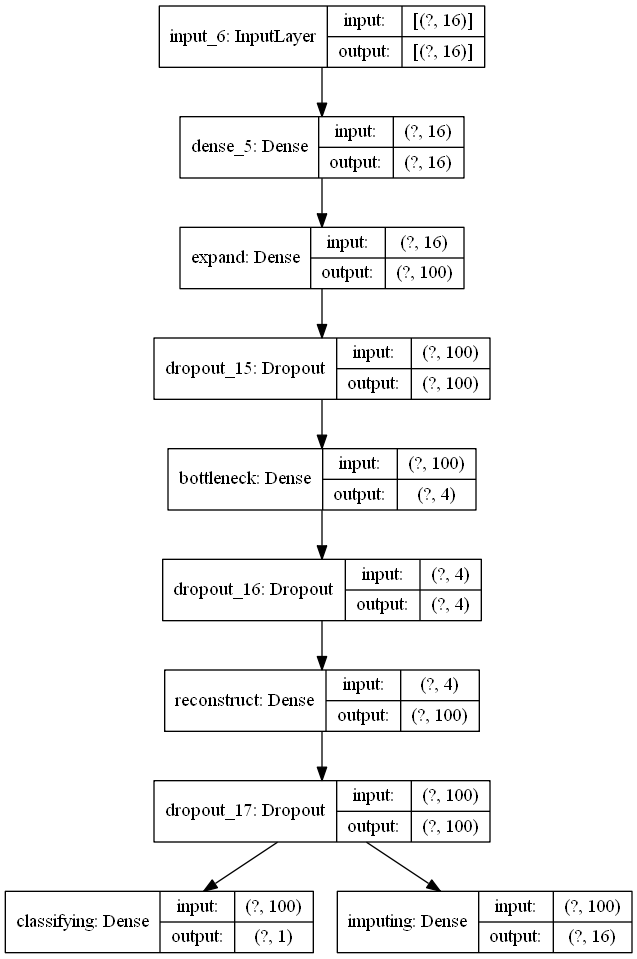

In [19]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)